In [1]:
import pandas as pd
import numpy as np 

ENDERECO_DADOS = 'https://www.ispdados.rj.gov.br/Arquivos/BaseDPEvolucaoMensalCisp.csv'

try:
    print('Carregando os dados...')
    df_ocorrencia = pd.read_csv(ENDERECO_DADOS, sep=';', encoding='iso-8859-1')

    print(df_ocorrencia.head())

    print('Dados carregados com sucesso!')
except Exception as e:
    print(f'Erro ao carregar os dados: {e}')
    exit()

Carregando os dados...
   cisp  mes   ano  mes_ano  aisp  risp           munic    mcirc   regiao  \
0     1    1  2003  2003m01     5     1  Rio de Janeiro  3304557  Capital   
1     4    1  2003  2003m01     5     1  Rio de Janeiro  3304557  Capital   
2     5    1  2003  2003m01     5     1  Rio de Janeiro  3304557  Capital   
3     6    1  2003  2003m01     1     1  Rio de Janeiro  3304557  Capital   
4     7    1  2003  2003m01     1     1  Rio de Janeiro  3304557  Capital   

   hom_doloso  ...  cmp  cmba  ameaca  pessoas_desaparecidas  \
0           0  ...  NaN   NaN      21                      2   
1           3  ...  NaN   NaN      15                      6   
2           3  ...  NaN   NaN      47                      2   
3           6  ...  NaN   NaN      26                      2   
4           4  ...  NaN   NaN      10                      1   

   encontro_cadaver  encontro_ossada  pol_militares_mortos_serv  \
0                 0                0                          

In [2]:
#recebendo dados 

try: 

    df_veiculos = df_ocorrencia[['cisp', 'roubo_veiculo', 'recuperacao_veiculos']] 

    df_total_veiculos = df_veiculos.groupby('cisp').sum(['roubo', 'recuperacao_veiculos']).reset_index() 

    print(df_total_veiculos) 

 
except Exception as e: 

    print(f'Erro: {e}') 

    exit() 


     cisp  roubo_veiculo  recuperacao_veiculos
0       1            565                   536
1       4           2165                  1903
2       5           1316                  1546
3       6           4516                  7974
4       7           1997                  1824
..    ...            ...                   ...
133   159            283                   338
134   165            500                   647
135   166            968                  1487
136   167            105                   399
137   168             62                   165

[138 rows x 3 columns]


In [3]:
# Calculando a Correlação
try:
    df_total_veiculos_cut = (
        df_total_veiculos[
            df_total_veiculos['roubo_veiculo'] < np.percentile(df_total_veiculos['roubo_veiculo'], 95)
        ] 
    )

    df_total_veiculos_cut = (
        df_total_veiculos[
            df_total_veiculos['recuperacao_veiculos'] < np.percentile(df_total_veiculos['recuperacao_veiculos'], 99)
        ] 
    )

    # Arrays
    array_roubo_veiculo = np.array(df_total_veiculos_cut['roubo_veiculo'])
    array_recuperacao_veiculos = np.array(df_total_veiculos_cut['recuperacao_veiculos'])
    # Calculando a correlação
    correlacao = np.corrcoef(array_roubo_veiculo, array_recuperacao_veiculos)[0, 1]

    print(f"Correlação: {correlacao:.2f}")

except Exception as e:
    print(f"Erro ao calcular a correlação: {e}")
    exit()

Correlação: 0.92


In [4]:
try:
     # pip install scikit-learn
    print('Iniciando a regressão linear...')

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        array_roubo_veiculo,  # Variável independente
        array_recuperacao_veiculos,  # Variável dependente
        test_size=0.2,  # 80% treino, 20% teste
        random_state=42  # Para reprodutibilidade
    )

    # Normalizando os dados
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, 1))
    X_test = scaler.transform(X_test.reshape(-1, 1))

    # Treinando o modelo
    from sklearn.linear_model import LinearRegression
    modelo = LinearRegression()
    modelo.fit(X_train, y_train)  # Treinando

    r2_score = modelo.score(X_test, y_test)  # Avaliando
    print(f"R² score: {r2_score:.2f}")
except Exception as e:
    print(f'Erro ao realizar a regressão linear: {e}')
    exit()

Iniciando a regressão linear...
R² score: 0.81


In [5]:
try:
    # Array de provisões 35000, 43000, 50000

    array_roubo_veiculo_pred = np.array([35000, 43000, 50000])
    array_roubo_veiculo_pred_scaled = scaler.transform(array_roubo_veiculo_pred.reshape(-1, 1))

    recup_pred = modelo.predict(array_roubo_veiculo_pred_scaled)
    print("Provisões de recuperação de veículos: ", recup_pred)

except Exception as e:
    print(f'Erro ao fazer previsões: {e}')
    exit()


Provisões de recuperação de veículos:  [22843.25828419 27962.65770392 32442.13219618]


Avaliando o modelo de previsões...


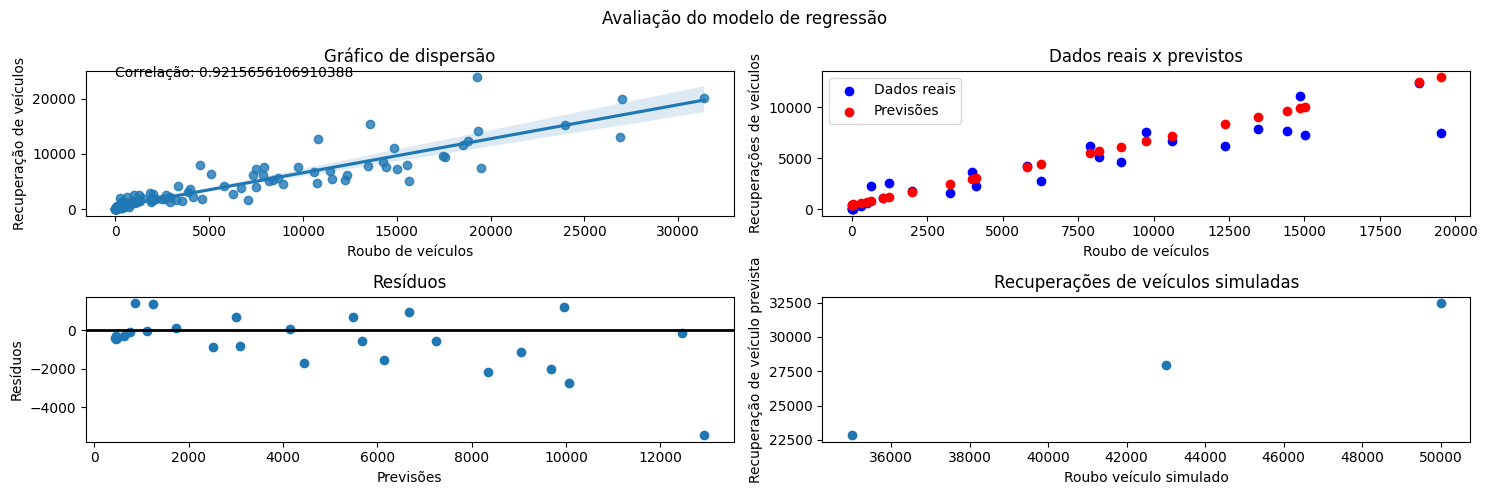

In [6]:
#plot
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    print('Avaliando o modelo de previsões...')

    plt.subplots(2, 2, figsize=(15, 5))
    plt.suptitle('Avaliação do modelo de regressão')


    #### POSIÇÃO 1: Gráfico de Dispersão entre os arrays
    # pip install seaborn
    plt.subplot(2, 2, 1)

    sns.regplot(x=array_roubo_veiculo, y=array_recuperacao_veiculos)
    plt.title('Gráfico de dispersão')
    plt.xlabel('Roubo de veículos')
    plt.ylabel('Recuperação de veículos')

    # Posicionar o texto no início do gráfico
    plt.text(min(array_roubo_veiculo),
             max(array_recuperacao_veiculos),
             f'Correlação: {correlacao}',
             fontsize=10)


    #### POSIÇÃO 2: Gráfico de dispersão entre os dados reais e previsto
    plt.subplot(2, 2, 2)

    # Testar o modelo preditivo nos dados de X_teste
    # Saída na escal original dos dados
    y_pred = modelo.predict(X_test)

    # Retornar os dados de teste para escala real
    X_test = scaler.inverse_transform(X_test)

    # Gráfico de dispersão sem a linha de regressão
    plt.scatter(X_test, y_test, color='blue', label='Dados reais')
    plt.scatter(X_test, y_pred, color = 'red', label='Previsões')

    plt.title('Dados reais x previstos')
    plt.xlabel('Roubo de veículos')
    plt.ylabel('Recuperações de veículos')

    plt.legend()


    ##### POSIÇÃO 3: Resíduos
    plt.subplot(2, 2, 3)

    # RESÍDUOS: Diferença entre valores reais e previstos (y_test - y_pred)
    # Análise dos resíduos ajuda a verificar, se o modelo está capturando bem
    # os padrões dos dados. 
    # Bons modelos têm resíduos próximos de 0.
    # Os dados devem ser distribuídos aleatoriamente.
    # Se tiverem um padrão, o modelo não é confiável
    residuos = y_test - y_pred

    # plotar em gráfico de dispersão
    plt.scatter(y_pred, residuos)

    # adicioanar uma linha constante no 0
    plt.axhline(y=0, color='black', linewidth=2)

    plt.title('Resíduos')
    plt.xlabel('Previsões')
    plt.ylabel('Resíduos')


    #### POSIÇÃO 4: Dispersão dos valores simulados
    plt.subplot(2, 2, 4)
    
    plt.scatter(array_roubo_veiculo_pred, recup_pred)

    plt.title('Recuperações de veículos simuladas')
    plt.xlabel('Roubo veículo simulado')
    plt.ylabel('Recuperação de veículo prevista')

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f'Erro ao plotar os dados: {e}')
    exit()